# Neuro-Symbolic Reasoning in Abstract Urban Environments

 ### Define City Elements & Abstractions

In [74]:
import os
import networkx as nx
import matplotlib.pyplot as plt
from openai import OpenAI
from dotenv import load_dotenv
from PIL import Image
import io
import requests
import imageio.v2 as imageio
import numpy as np
import matplotlib.animation as animation

load_dotenv()

class Agent:
    def __init__(self, id, agent_type, position=None, old=False):
        self.id = id
        self.type = agent_type
        self.position = position
        self.old = old

    def is_old(self):
        return self.old

def distance(pos1, pos2):
    return abs(pos1[0] - pos2[0]) + abs(pos1[1] - pos2[1])

In [35]:
def distance(pos1, pos2):
    return abs(pos1[0] - pos2[0]) + abs(pos1[1] - pos2[1])

### Define FOL Rules
### Rule example: Stop(X) :- Not(IsAmbulance(X)), Not(IsOld(X)), IsAtIntersection(X), IsInIntersection(Y).

In [75]:
def rule_stop_nonambulance_old(agent, agents):
    if agent.type == 'Ambulance' or agent.is_old():
        return False
    return is_at_intersection(agent) and any(is_in_intersection(a) for a in agents if a.id != agent.id)

def is_at_intersection(agent):
    return agent.position in [(0, 0), (1, 1)]

def is_in_intersection(agent):
    return is_at_intersection(agent)

### Simulator Structure

In [76]:
class LogiCityEnv:
    def __init__(self, graph, agents):
        self.graph = graph
        self.agents = agents

    def reset(self):
        for i, agent in enumerate(self.agents):
            agent.position = (i % 2, i // 2)
        return self.agents

    def step(self, agent_id, action):
        agent = next(a for a in self.agents if a.id == agent_id)
        if action == "move":
            agent.position = (agent.position[0] + 1, agent.position[1])
        return self.agents, 1.0, False

    def render(self):
        return f"Agent positions: {[a.position for a in self.agents]}"

### Visual Reasoning Task (VAP)

In [77]:
def construct_prompt_with_image(image, agents_info):
    return f"Scene: {image}\nAgents: {agents_info}\nWhat action should each agent take?"

### LLM-Only Predictor

In [ ]:
client = OpenAI(api_key=os.environ.get("OPEN_AI_API_KEY"))

def ask_llm(prompt):
    response = client.chat.completions.create(
        model="gpt-4",
        messages=[
            {"role": "system", "content": "You are a symbolic reasoner in an abstract city."},
            {"role": "user", "content": prompt}
        ]
    )
    return response.choices[0].message.content

### Evaluation Logic

In [79]:
city = nx.Graph()
city.add_edges_from([("A", "B"), ("B", "C"), ("C", "D"), ("D", "A")])
agents = [Agent("1", "Car"), Agent("2", "Ambulance"), Agent("3", "Car", old=True)]
env = LogiCityEnv(city, agents)
state = env.reset()
scene = env.render()

prompt = construct_prompt_with_image(scene, [(a.id, a.type) for a in agents])
print("LLM Reasoning Result:\n", ask_llm(prompt))


LLM Reasoning Result:
 Based on their given positions, it seems like they are situated in different places across the city. However, without any further context, guidance or purpose, it's hard to specify which actions they should take. Here's a general suggestion:

1. 'Car' at position (0,0) might consider moving to a different part of the city, possibly by moving along the x or y-axis to (1,0) or (0,1).

2. 'Ambulance' at position (1,0) should prioritize emergency calls. If there's no emergency, it could remain stationary to conserve fuel or relocate to an area of the city with a higher demand for medical assistance.

3. 'Car' at position (0,1) could also consider moving to a different part of the city or remain stationary depending on the driver's purpose.

Remember, these are purely speculative as no specific objectives or conditions were given in the setup.


### Hybrid Neuro-Symbolic Agent

In [80]:
class HybridAgent:
    def __init__(self, agent):
        self.agent = agent

    def decide_action(self, env):
        if rule_stop_nonambulance_old(self.agent, env.agents):
            return "stop"
        return "move"


### Load Image Sequence

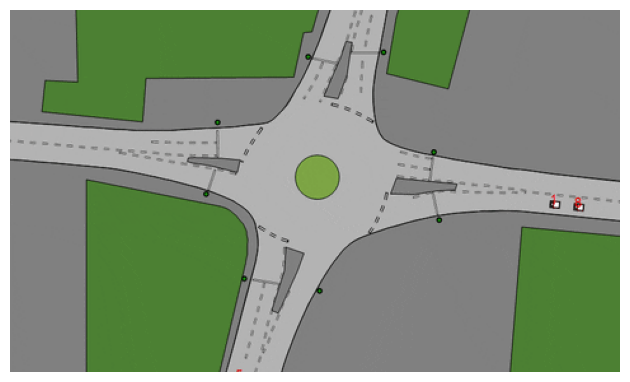

In [81]:
frames = []
image_dir = os.path.expanduser("~/Downloads/animation_simulation")
if os.path.exists(image_dir):
    image_files = sorted([
        os.path.join(image_dir, f) for f in os.listdir(image_dir)
        if f.lower().endswith(('.tiff', '.tif'))
    ])[:50]
    if not image_files:
        print("No TIFF files found in:", image_dir)
    for file_path in image_files:
        try:
            with Image.open(file_path) as img:
                frames.append(np.array(img.convert("RGB")))
        except Exception as img_err:
            print(f"Failed to load {file_path}:", img_err)
else:
    print("Image directory does not exist:", image_dir)
    print("Image directory does not exist:", image_dir)

def render_gif_simulation_with_reasoning(gif_frames):
    fig, ax = plt.subplots()
    img_disp = ax.imshow(gif_frames[0])
    text = ax.text(10, 10, '', color='white', fontsize=12, backgroundcolor='black')

    def update(frame_idx):
        frame = gif_frames[frame_idx % len(gif_frames)]
        img_disp.set_data(frame)
        prompt = f"Frame {frame_idx}: Describe the traffic agent's behavior."
        try:
            response = ask_llm(prompt)
            action = response.strip().splitlines()[0][:80]
        except Exception as e:
            action = f"LLM error: {e}"[:80]
        text.set_text(f"Frame {frame_idx}: {action}")
        return img_disp, text

    ani = animation.FuncAnimation(fig, update, frames=len(gif_frames), interval=1000, blit=False)
    plt.axis('off')
    plt.tight_layout()
    plt.show(block=True)

if frames:
    render_gif_simulation_with_reasoning(frames)
else:
    print("No frames to render.")

Symbolic Reasoning Result:
Agent 1: move
Agent 2: move
Agent 3: move


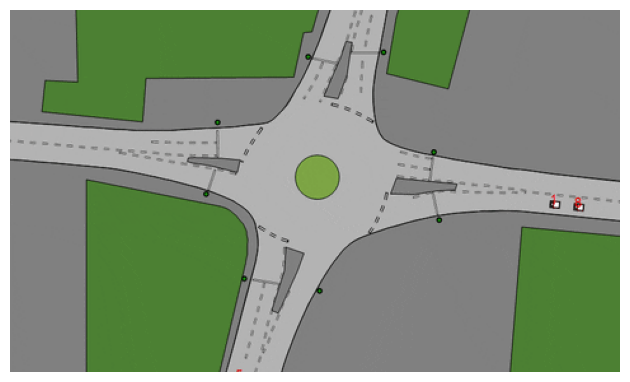

In [84]:
# LogiCity-Inspired Neuro-Symbolic Reasoning Project (VS Code Version)

# STEP 1: Environment Setup
# python -m venv logicity_env
# source logicity_env/bin/activate (or .\logicity_env\Scripts\activate on Windows)
# pip install networkx matplotlib python-dotenv pillow imageio

%matplotlib inline

# STEP 2: Define City Elements & Abstractions
import os
import networkx as nx
import matplotlib.pyplot as plt
from dotenv import load_dotenv
from PIL import Image
import io
import requests
import imageio.v2 as imageio
import numpy as np
import matplotlib.animation as animation

load_dotenv()

class Agent:
    def __init__(self, id, agent_type, position=None, old=False):
        self.id = id
        self.type = agent_type
        self.position = position
        self.old = old

    def is_old(self):
        return self.old

def distance(pos1, pos2):
    return abs(pos1[0] - pos2[0]) + abs(pos1[1] - pos2[1])

# STEP 3: Define FOL Rules
def rule_stop_nonambulance_old(agent, agents):
    if agent.type == 'Ambulance' or agent.is_old():
        return False
    return is_at_intersection(agent) and any(is_in_intersection(a) for a in agents if a.id != agent.id)

def is_at_intersection(agent):
    return agent.position in [(0, 0), (1, 1)]

def is_in_intersection(agent):
    return is_at_intersection(agent)

# STEP 4: Simulator Structure
class LogiCityEnv:
    def __init__(self, graph, agents):
        self.graph = graph
        self.agents = agents

    def reset(self):
        for i, agent in enumerate(self.agents):
            agent.position = (i % 2, i // 2)
        return self.agents

    def step(self, agent_id, action):
        agent = next(a for a in self.agents if a.id == agent_id)
        if action == "move":
            agent.position = (agent.position[0] + 1, agent.position[1])
        return self.agents, 1.0, False

    def render(self):
        return f"Agent positions: {[a.position for a in self.agents]}"

# STEP 5: Visual Reasoning Task

def construct_reasoning_prompt(image_summary, agents_info):
    return f"Scene: {image_summary}\nAgents: {agents_info}\nWhat action should each agent take based on logic rules?"

# STEP 6: Logic-Based Predictor (DeepProbLog-ready)

def symbolic_decision(agent, agents):
    return "stop" if rule_stop_nonambulance_old(agent, agents) else "move"

# STEP 7: Evaluation Logic
city = nx.Graph()
city.add_edges_from([("A", "B"), ("B", "C"), ("C", "D"), ("D", "A")])
agents = [Agent("1", "Car"), Agent("2", "Ambulance"), Agent("3", "Car", old=True)]
env = LogiCityEnv(city, agents)
state = env.reset()
scene = env.render()

print("Symbolic Reasoning Result:")
for agent in agents:
    print(f"Agent {agent.id}: {symbolic_decision(agent, agents)}")

# STEP 8: Hybrid Neuro-Symbolic Agent
class HybridAgent:
    def __init__(self, agent):
        self.agent = agent

    def decide_action(self, env):
        return symbolic_decision(self.agent, env.agents)

# STEP 9: Load Image Sequence from Folder
frames = []
image_dir = os.path.expanduser("~/Downloads/animation_simulation")
if os.path.exists(image_dir):
    image_files = sorted([
        os.path.join(image_dir, f) for f in os.listdir(image_dir)
        if f.lower().endswith(('.tiff', '.tif'))
    ])[:50]
    if not image_files:
        print("No TIFF files found in:", image_dir)
    for file_path in image_files:
        try:
            with Image.open(file_path) as img:
                frames.append(np.array(img.convert("RGB")))
        except Exception as img_err:
            print(f"Failed to load {file_path}:", img_err)
else:
    print("Image directory does not exist:", image_dir)

# STEP 10: Animate Simulation with Symbolic Reasoning

def render_simulation_with_symbolic_logic(gif_frames, agents):
    fig, ax = plt.subplots()
    img_disp = ax.imshow(gif_frames[0])
    text = ax.text(10, 10, '', color='white', fontsize=12, backgroundcolor='black')

    def update(frame_idx):
        frame = gif_frames[frame_idx % len(gif_frames)]
        img_disp.set_data(frame)
        msg = ", ".join([
            f"A{a.id}:{symbolic_decision(a, agents)}" for a in agents
        ])
        text.set_text(f"Frame {frame_idx}: {msg}")
        return img_disp, text

    ani = animation.FuncAnimation(fig, update, frames=len(gif_frames), interval=1000, blit=False)
    plt.axis('off')
    plt.tight_layout()
    plt.show(block=True)

if frames:
    render_simulation_with_symbolic_logic(frames, agents)
else:
    print("No frames to render.")
